In [4]:
import numpy as np
import json
import os
import sys
import matplotlib.pyplot as plt
import scienceplots  # optional, requires latex
plt.style.use(['science', 'grid'])

# set matplotlib font size
plt.rcParams.update({
    "font.size": 18,         # Default font size for all text
    # "axes.labelsize": 15,    # X and Y label font size
    # "xtick.labelsize": 15,   # X-axis tick label font size
    # "ytick.labelsize": 15,   # Y-axis tick label font size
    # "legend.fontsize": 15,   # Legend font size
})

# Import plotting utility functions
sys.path.append('../')
from plot_util import (init_metrics, update_metrics, init_variable, update_variable,
                       plot_field, plot_field_residual, plot_field_columns, make_formatter, subsample_steps,
                        animate_frame, moving_average, moving_min)


In [65]:
# Select run to plot

results_folder = r"./results"

measurments_type = ["displacement","strain","DIC"][0]
iteration = int(1e8)
time = [3, False][0]
n_measurments = 100
noise = [0,1e-6][1]
run_number = 0

run = f"{measurments_type}_x{n_measurments}_{noise}noise_{time if time else iteration}{'min' if time else 'iter'}{f'-{run_number}' if run_number else ''}"

run_folder = os.path.join(results_folder, run)+"/"

In [66]:
# Load Configuration and Data

with open(os.path.join(run_folder, "config.json")) as f:
    run_config = json.load(f)

def read_data_file(filename):
    with open(filename, "r") as f:
        steps = []
        values = []
        for line in f.readlines():
            step, value = line.strip().split(' ', 1)
            steps.append(eval(step))
            values.append(eval(value))
    return steps, values

# Load loss and variable history data
loss_history = np.loadtxt(os.path.join(run_folder, "loss_history.dat"))
# loss_history_mean = moving_average(loss_history, 20)
# loss_history_min = moving_min(loss_history, 20)
variables_history = read_data_file(os.path.join(run_folder, "variables_history.dat"))

# Compute different metrics
residuals = loss_history[:, -1]
PDE_loss = np.mean(loss_history[:, 1:2], axis=1)
BC_loss = np.mean(loss_history[:, 2:6], axis=1)
DIC_loss = np.mean(loss_history[:, 6:7], axis=1)
steps_loaded = loss_history[:, 0]

# Extract material parameters from config
D_init = run_config["problem"]["D_init"] 
D_actual = run_config["problem"]["D_actual"] 

D_history = np.array(variables_history[1])[:len(steps_loaded), 0] 

D_name = r"$D$"

metrics = [residuals, PDE_loss, BC_loss, DIC_loss]
metrics_names = ["Rel. l2 error", "PDE Loss", "BC Loss", "DIC Loss"]

# Configure x-axis based on iterations or elapsed time
step_type = "time"  # or "iteration"
time_unit = "min"   # or "s"
t_Dlapsed = run_config["execution"]["elapsed"]
if step_type == "time":
    steps = np.array(steps_loaded) * t_Dlapsed / steps_loaded[-1]
    if time_unit == "min":
        steps = steps / 60
else:
    steps = steps_loaded

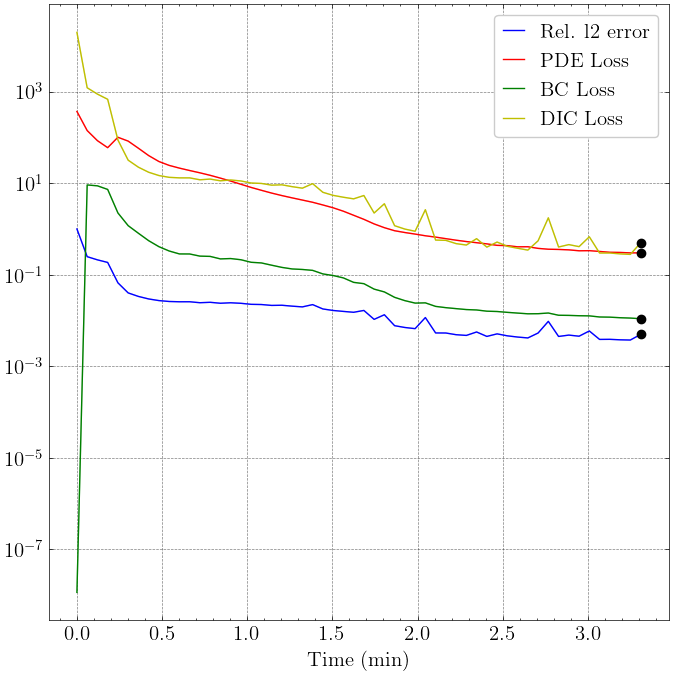

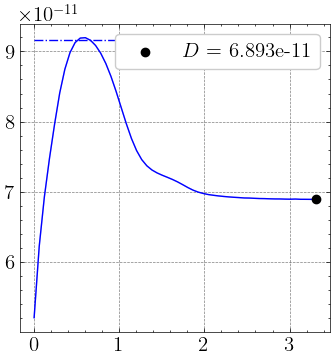

Parameter      Initial        Final          Reference      Rel. Error (%) 
D              0.0000         0.0000         0.0000         24.69          


In [67]:
# Plot Metrics and Parameter Evolution

iteration = len(steps) - 1
# --- Plot Metrics ---
metrics_idx = [0, 1, 2, 3][:]
fig, ax_metric = plt.subplots(1, 1, figsize=(8, 8), dpi=100)
lines, scatters = init_metrics(ax_metric, steps, metrics, metrics_names, step_type=step_type, time_unit=time_unit, metrics_idx=metrics_idx)
update_metrics(iteration, lines, scatters, steps, metrics, metrics_idx=metrics_idx)
plt.show()

# --- Plot Parameter Evolution ---
fig, ax_var = plt.subplots(1, 1, figsize=(4, 4), dpi=100)
line_D, scatter_D, ax_var = init_variable(ax_var, steps, D_actual, D_history, D_name)
update_variable(iteration, line_D, scatter_D, ax_var, steps, D_history, D_actual,  D_name)
plt.show()

# --- Print Final Parameter Values ---
D_final = np.mean(D_history[-10:])
print(f"{'Parameter':<15}{'Initial':<15}{'Final':<15}{'Reference':<15}{'Rel. Error (%)':<15}")
print(f"{'D':<15}{D_init:<15.4f}{D_final:<15.4f}{D_actual:<15.4f}{(abs(D_final - D_actual) / D_actual * 100):<15.2f}")

# --- Combined Plot ---
# fig, axs_combined = plt.subplots(2, 1, figsize=(4, 8), dpi=150)
# lines, scatters = init_metrics(axs_combined[-1], steps, metrics, metrics_names, step_type=step_type, time_unit=time_unit, metrics_idx=[0])
# update_metrics(iteration, lines, scatters, steps, metrics, metrics_idx=[0])
# line_D, scatter_D, ax_var = init_variable(axs_combined[0], steps, D_actual, D_history, D_name)
# update_variable(iteration, line_D, scatter_D, ax_var, steps, D_history, D_actual,  D_name)
# plt.show()

In [68]:
# Load Field Data
field_names = run_config["network"]["logged_fields"]
fields_plotted = [0] # 0: W to be loaded

fields = [None] * 5
for fid in fields_plotted:
    field_name = field_names[fid]
    _, V_pinn = read_data_file(os.path.join(run_folder, f"{field_name}_history.dat"))
    fields[fid] = np.array(V_pinn)

Fig width: 8.0, set it to 2.67 < 6.34 (A4 with margins) in latex to have a printed font size of 6 for titles and 5.00 for the axis


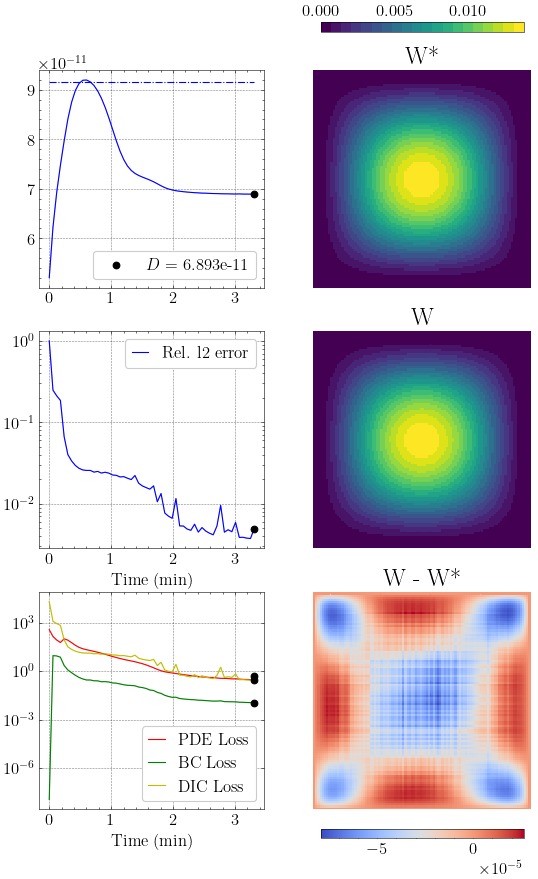

In [70]:
# Field Plotting
import matplotlib.colors as mcolors
from scipy.interpolate import RegularGridInterpolator
import plot_util 
from importlib import reload
reload(plot_util)
from plot_util import (init_metrics, update_metrics, init_variable, update_variable,
                       plot_field, plot_field_residual, plot_field_columns, make_formatter, subsample_steps,
                        animate_frame, moving_average, moving_min)

# --- Font size for printing ---
plotting_factor = 4
font_factor = 3
title_font_size = 6
axes_font_size = 5
plt.rcParams.update({
    "font.size": title_font_size*font_factor,         # Default font size for all text
    "figure.titlesize": title_font_size*font_factor, 
    "axes.labelsize": axes_font_size*font_factor,
    "xtick.labelsize": axes_font_size*font_factor,
    "ytick.labelsize": axes_font_size*font_factor,
    "legend.fontsize": axes_font_size*font_factor,
})


plot_metrics = 1 # 1 to plot metrics, 0 to not plot metrics
fields_plotted = [0] # 0: W to be plotted
n_fields = len(fields_plotted)

# --- Custom colormap ---
cmap = plt.get_cmap('viridis')
num_colors = 20
color_values = [cmap(i) for i in np.linspace(0, 1, num_colors)]
cmap = mcolors.ListedColormap(color_values)

# --- Load FEM reference solution and create interpolators ---
dir_path = r"./data_fem"
data = np.loadtxt(os.path.join(dir_path, "100x100.dat"))
X_val = data[:, :2]
u_val = data[:, 2:4]
stress_val = data[:, 7:10]
solution_val = np.hstack((u_val, stress_val))
n_mesh_points = int(np.sqrt(X_val.shape[0]))
x_grid = np.linspace(0, 3, n_mesh_points)
y_grid = np.linspace(0, 3, n_mesh_points)
interpolators = [RegularGridInterpolator((x_grid, y_grid),
                                          solution_val[:, i].reshape(n_mesh_points, n_mesh_points).T)
                 for i in range(solution_val.shape[1])]
func = lambda x: np.array([interp((x[:, 0], x[:, 1])) for interp in interpolators]).T

# --- Prepare a square grid for field plotting ---
iteration = len(steps) - 1
ngrid = 100
l_max = 3.0

Xmesh, Ymesh = np.meshgrid(np.linspace(0, l_max, ngrid), np.linspace(0, l_max, ngrid), indexing='ij')
# normdiff = set_normdiff(iteration, fields, fields_id, func, Xmesh, Ymesh)

# --- Plotting ---
subplot_width = plotting_factor
fig, ax = plt.subplots(3,plot_metrics+n_fields,figsize = (plot_metrics*subplot_width+n_fields*subplot_width,subplot_width*3),dpi = 40*plot_metrics+40*n_fields)
printed_font_size = 6
title_font_size = plt.rcParams['font.size']
axes_font_size = ax[0][0].get_xticklabels()[0].get_fontsize()
print(f"Fig width: {fig.get_figwidth()}, set it to {fig.get_figwidth()*printed_font_size/title_font_size:.2f} < 6.34 (A4 with margins) in latex to have a printed font size of {printed_font_size} for titles and {axes_font_size*printed_font_size/title_font_size:.2f} for the axis")

# Plot parameter evolution on ax_var
if plot_metrics:
    ax_var = ax[0][0]
    line_D, scatter_D, ax_variables = init_variable(
        ax_var, steps, D_actual, D_history, D_name
    )
    update_variable(iteration, line_D, scatter_D,
                    ax_var, steps, D_history, 
                    D_actual, D_name)

    # Plot metrics on ax_metric
    lines_res, scatters_res = init_metrics(ax[1][0], steps, metrics, metrics_names, 
                                step_type=step_type, time_unit=time_unit, metrics_idx=[0])
    update_metrics(iteration, lines_res, scatters_res, steps, metrics, metrics_idx=[0])

    # Plot metrics on ax_metric
    lines, scatters = init_metrics(ax[2][0], steps, metrics, metrics_names, 
                                step_type=step_type, time_unit=time_unit, metrics_idx=[1,2,3])
    update_metrics(iteration, lines, scatters, steps, metrics, metrics_idx=[1,2,3])


ims_field = []
ims_ref = []
ims_res = []
ax_fields = ax[:, plot_metrics:]
ims_ref, ims_field, ims_res = plot_field_columns(fig, ax_fields, fields, fields_plotted, iteration,
                                                  Xmesh, Ymesh, func, field_names, cmap, make_formatter)

plt.tight_layout
plt.show()

In [29]:
# Save figure
fig_name = f"{run}_"+ "_".join([field_names[fid] for fid in fields_plotted]) 
fig.savefig(f'./{fig_name}.png', dpi=500, bbox_inches='tight')

In [ ]:
# Animation
import matplotlib.animation as animation
from IPython.display import HTML

# Add time to the title
fig.suptitle(f"{step_type}: {steps[iteration]:.0f}{f'{time_unit}' if step_type == 'time' else ''}", fontsize=20, y=1)

# Prepare a list of frame indices (subsample if desired)
all_steps = list(range(len(steps)))
sub_factors = [1,2] + [3]*3  # Adjust subsampling factors as needed
frame_steps = list(subsample_steps(all_steps, sub_factors))

# Reuse the figure from Cell 4 (or create a new one if preferred)
anim = animation.FuncAnimation(
    fig,
    animate_frame,
    frames=frame_steps,
    fargs=(ims_field, ims_res, line_D, line_nu, scatter_D, scatter_nu,
           ax_var, lines, scatters, steps, time_unit, step_type,
           D_history, nu_history, D_actual, nu_actual,
           D_name, nu_name, metrics, fields, func, Xmesh, Ymesh, field_names, fields_plotted),
    interval=100,
    repeat=False
)

fps = 10
print("Video duration: ", len(frame_steps)/fps, "s")
# HTML(anim.to_jshtml())

Video duration:  13.5 s


In [ ]:
# Save video
fig_name = f"{run}_"+ "_".join([field_names[fid] for fid in fields_plotted]) 
extension = ".mp4"  # or ".gif"
video_name = f"{fig_name}_{step_type}{extension}"
anim.save(video_name, writer='ffmpeg', fps=fps)

print(f"Video saved at {video_name}")

Video saved at strain_x16_1e-06noise_5min_Ux_Uy_time_.mp4


<Figure size 350x262.5 with 0 Axes>